In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.tree import export_graphviz
import pydot

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import imblearn.pipeline

from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_tree

from hyperopt import hp
from hyperopt import fmin, tpe

%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


In [44]:
shap.initjs()

# EDA

## Import Data

In [7]:
df = pd.read_csv('./creditcardfraud_data.csv')

In [8]:
df.shape

(284807, 31)

In [9]:
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [10]:
# Convert all columns to lower case
df.columns = [col.lower() for col in df.columns]

df.head()

time        v1        v2        v3        v4        v5        v6        v7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         v8        v9  ...       v21       v22       v23       v24       v25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        v26       v27       v28  amount  class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

## Basic Checks for Nulls & Descriptive Statistics

In [6]:
# Check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    284807 non-null  float64
 1   v1      284807 non-null  float64
 2   v2      284807 non-null  float64
 3   v3      284807 non-null  float64
 4   v4      284807 non-null  float64
 5   v5      284807 non-null  float64
 6   v6      284807 non-null  float64
 7   v7      284807 non-null  float64
 8   v8      284807 non-null  float64
 9   v9      284807 non-null  float64
 10  v10     284807 non-null  float64
 11  v11     284807 non-null  float64
 12  v12     284807 non-null  float64
 13  v13     284807 non-null  float64
 14  v14     284807 non-null  float64
 15  v15     284807 non-null  float64
 16  v16     284807 non-null  float64
 17  v17     284807 non-null  float64
 18  v18     284807 non-null  float64
 19  v19     284807 non-null  float64
 20  v20     284807 non-null  float64
 21  v21     28

In [65]:
df.describe()

time            v1            v2            v3            v4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.165980e-15  3.416908e-16 -1.373150e-15  2.086869e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 v5            v6            v7            v8            v9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.490107e-15 -5.556467e-16  1.177556e-16 -2.406455e-15   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01   
25%   -6.915971e-01 -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01   
50%   -5.433583e-02 -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02   
75%    6.119264e-01  3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01   
max    3.480167e+01  7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01   

       ...           v21           v22           v23           v24  \
count  ...  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   ...  1.656562e-16 -3.444850e-16  2.578648e-16  4.471968e-15   
std    ...  7.345240e-01  7.257016e-01  6.244603e-01  6.056471e-01   
min    ... -3.483038e+01 -1.093314e+01 -4.480774e+01 -2.836627e+00   
25%    ... -2.283949e-01 -5.423504e-01 -1.618463e-01 -3.545861e-01   
50%    ... -2.945017e-02  6.781943e-03 -1.119293e-02  4.097606e-02   
75%    ...  1.863772e-01  5.285536e-01  1.476421e-01  4.395266e-01   
max    ...  2.720284e+01  1.050309e+01  2.252841e+01  4.584549e+00   

                v25           v26           v27           v28         amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean   5.340915e-16  1.687098e-15 -3.666453e-16 -1.220404e-16      88.349619   
std    5.212781e-01  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.029540e+01 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -3.171451e-01 -3.269839e-01 -7.083953e-02 -5.295979e-02       5.600000   
50%    1.659350e-02 -5.213911e-02  1.342146e-03  1.124383e-02      22.000000   
75%    3.507156e-01  2.409522e-01  9.104512e-02  7.827995e-02      77.165000   
max    7.519589e+00  3.517346e+00  3.161220e+01  3.384781e+01   25691.160000   

               class  
count  284807.000000  
mean        0.001727  
std         0.041527  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  

[8 rows x 31 columns]

## Pairplots of Features and Target Variable

In [17]:
# Define all features
orig_feats = [col for col in df.columns if 'class' not in col]

len(orig_feats)

30

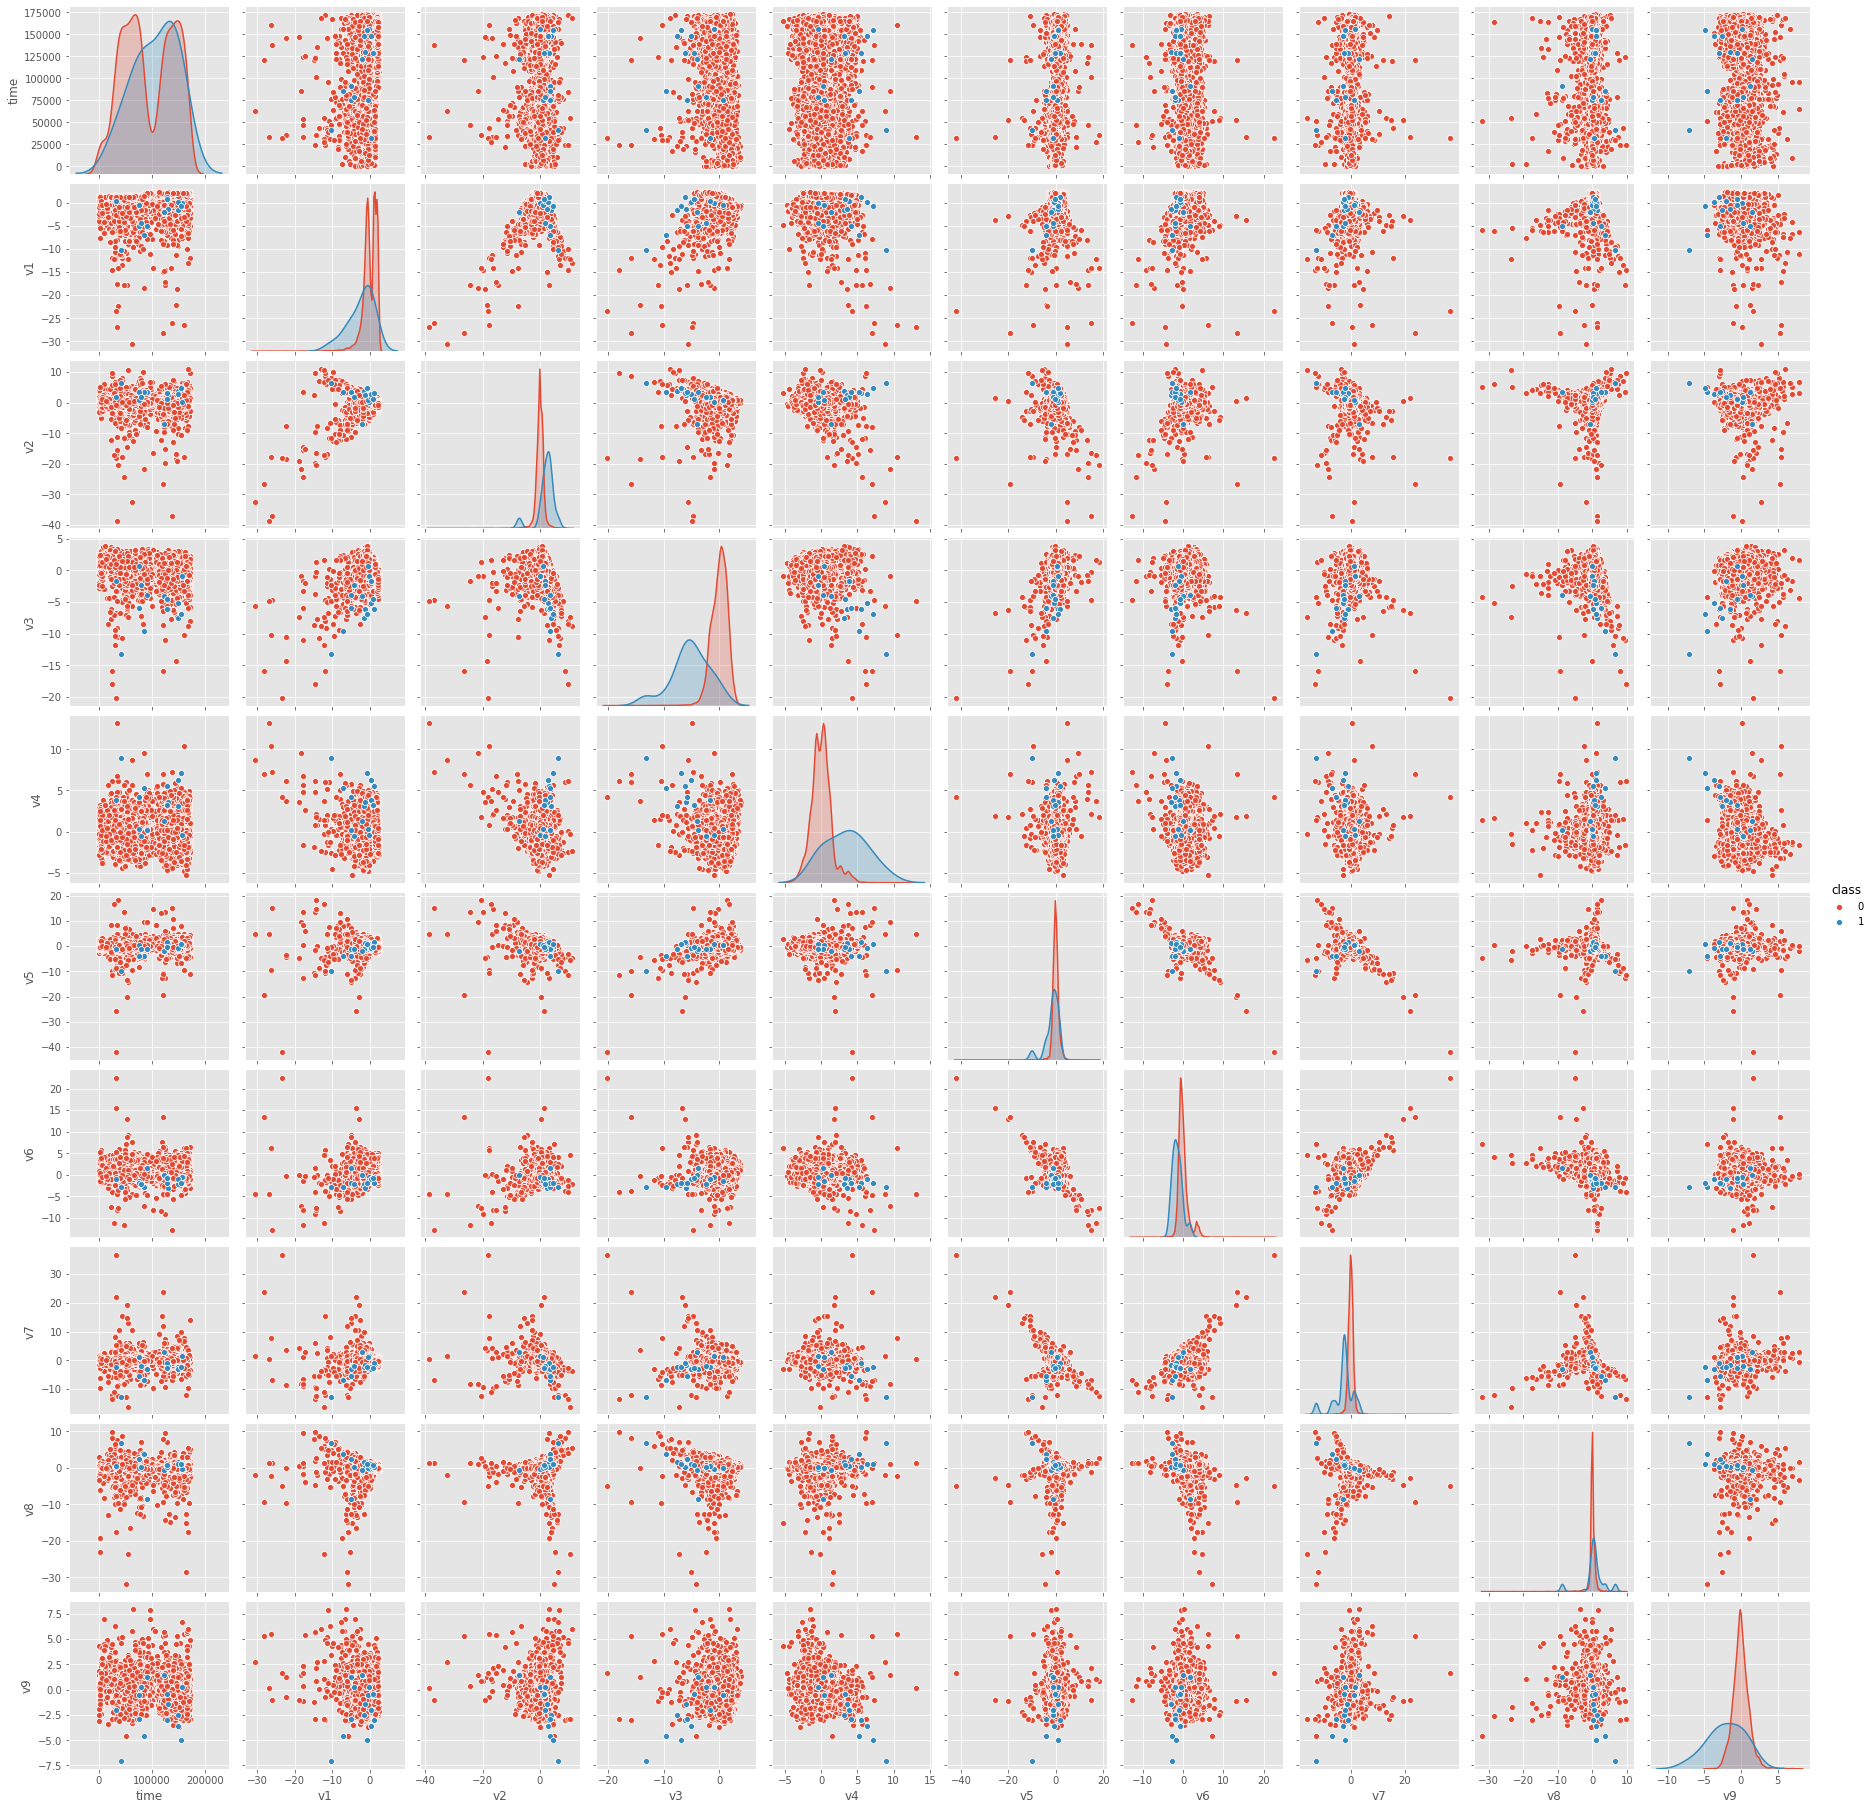

In [8]:
sns.pairplot(df[orig_feats[:10]+['class']].sample(10000, random_state=1), hue='class')

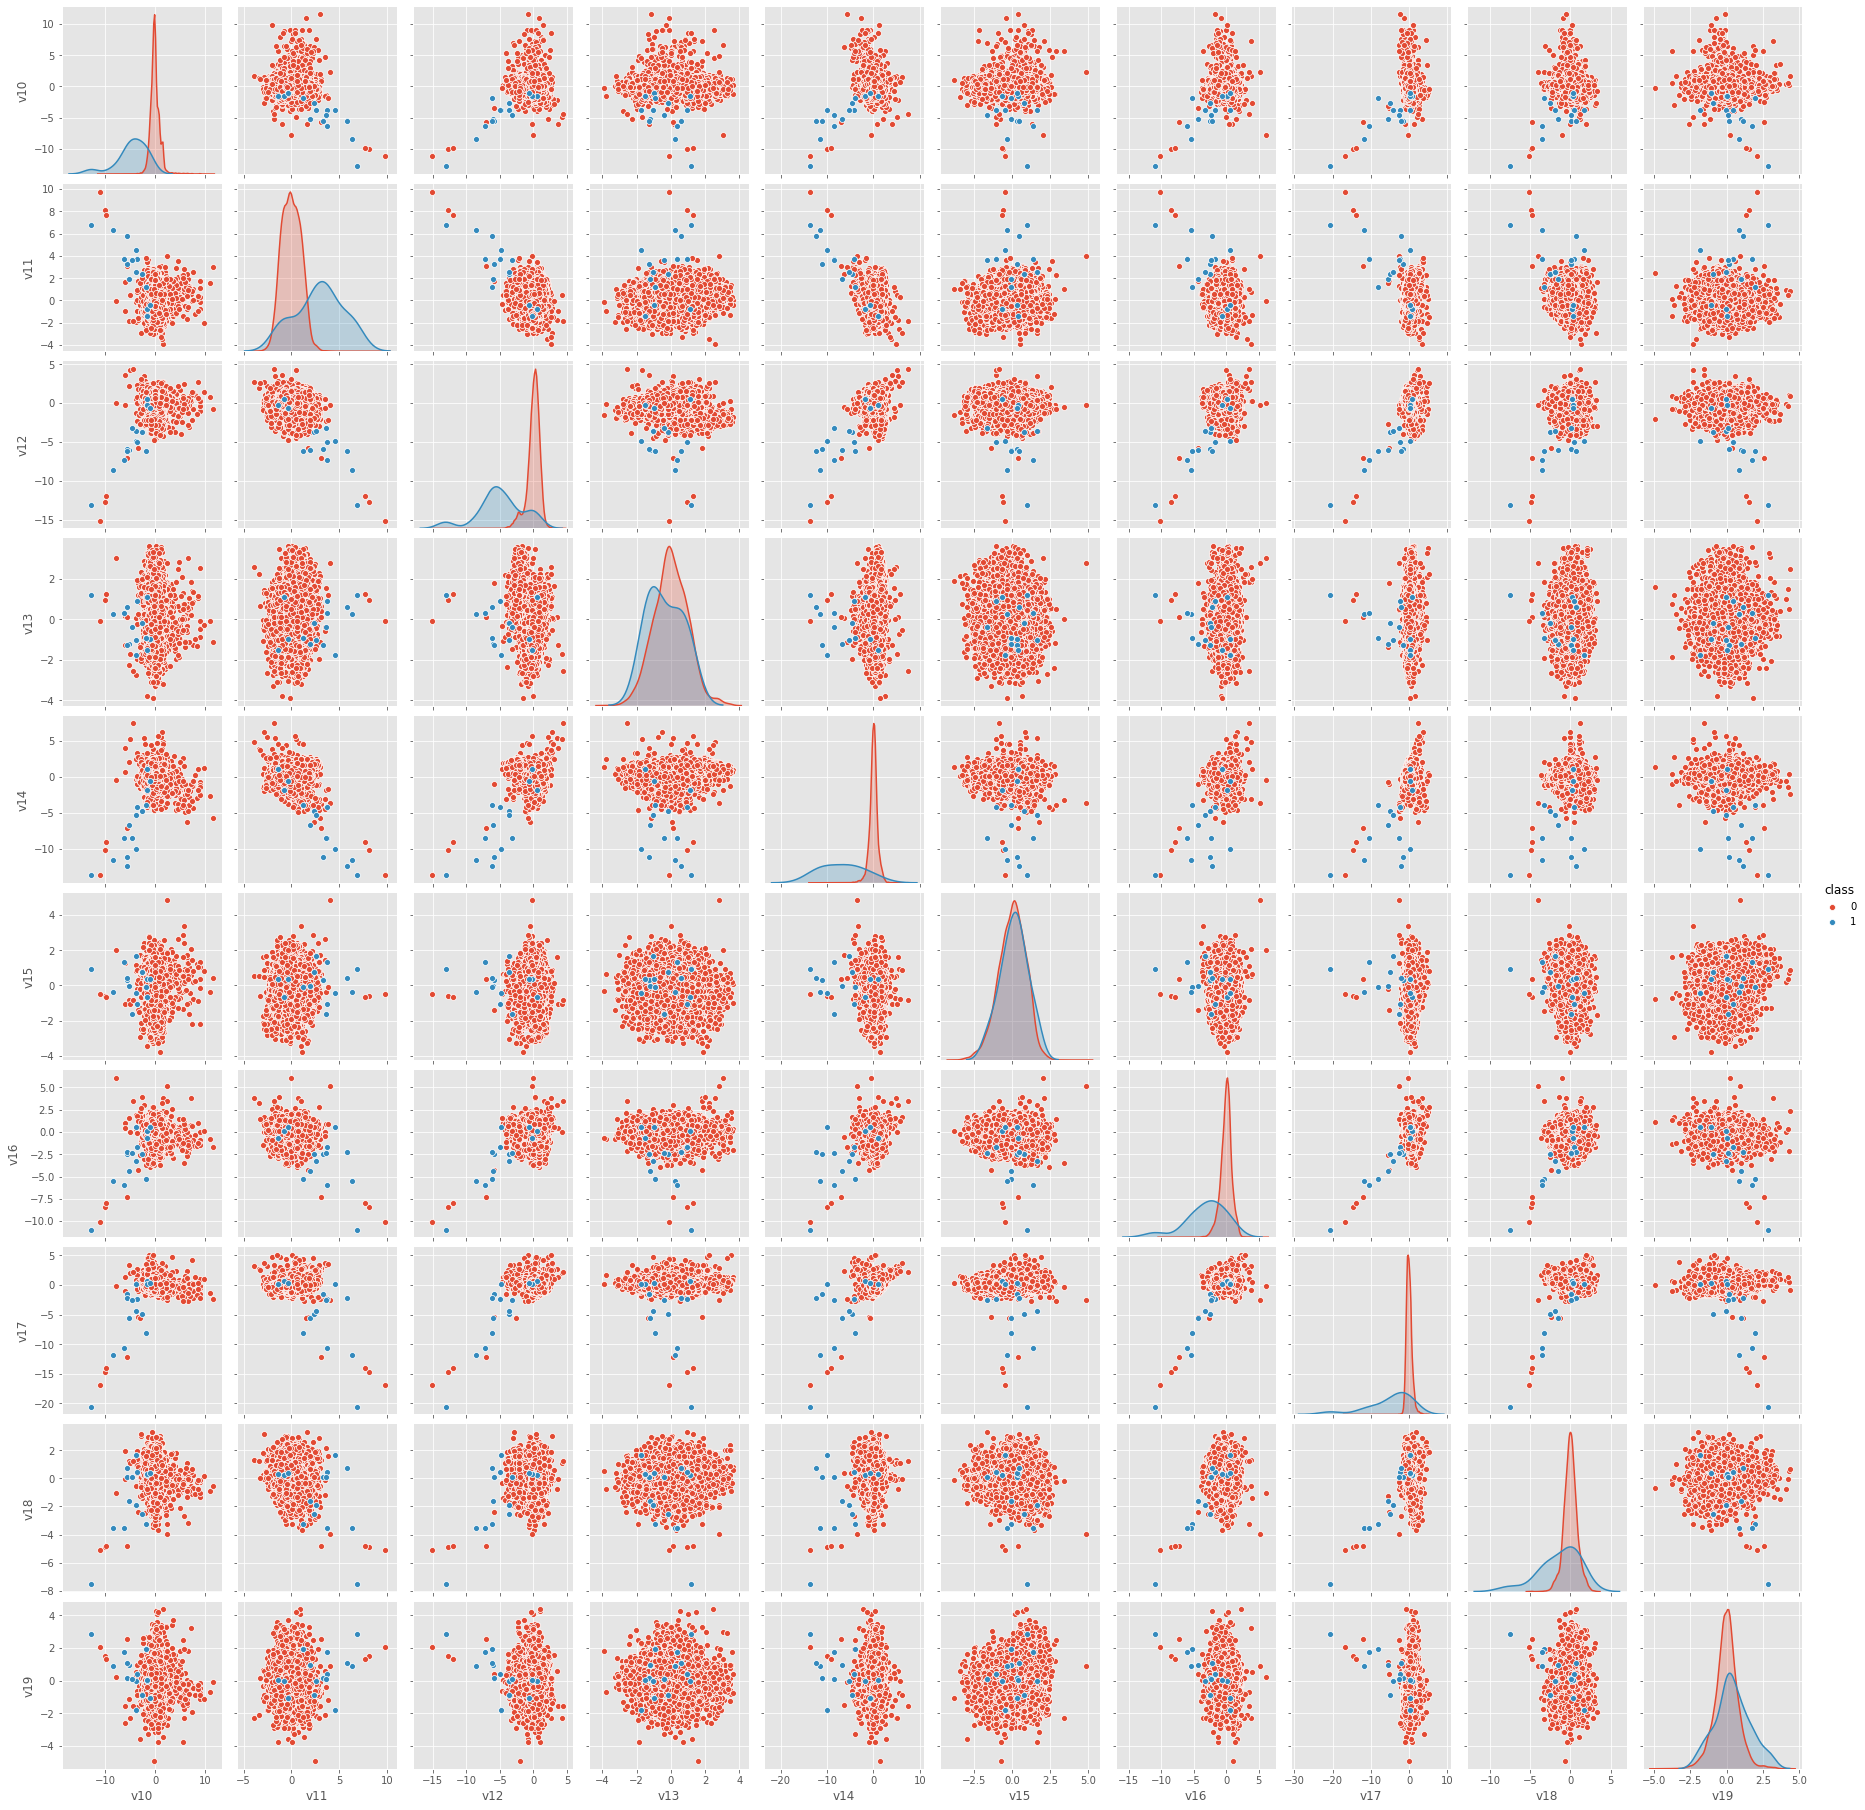

In [9]:
sns.pairplot(df[orig_feats[10:20]+['class']].sample(10000, random_state=1), hue='class')

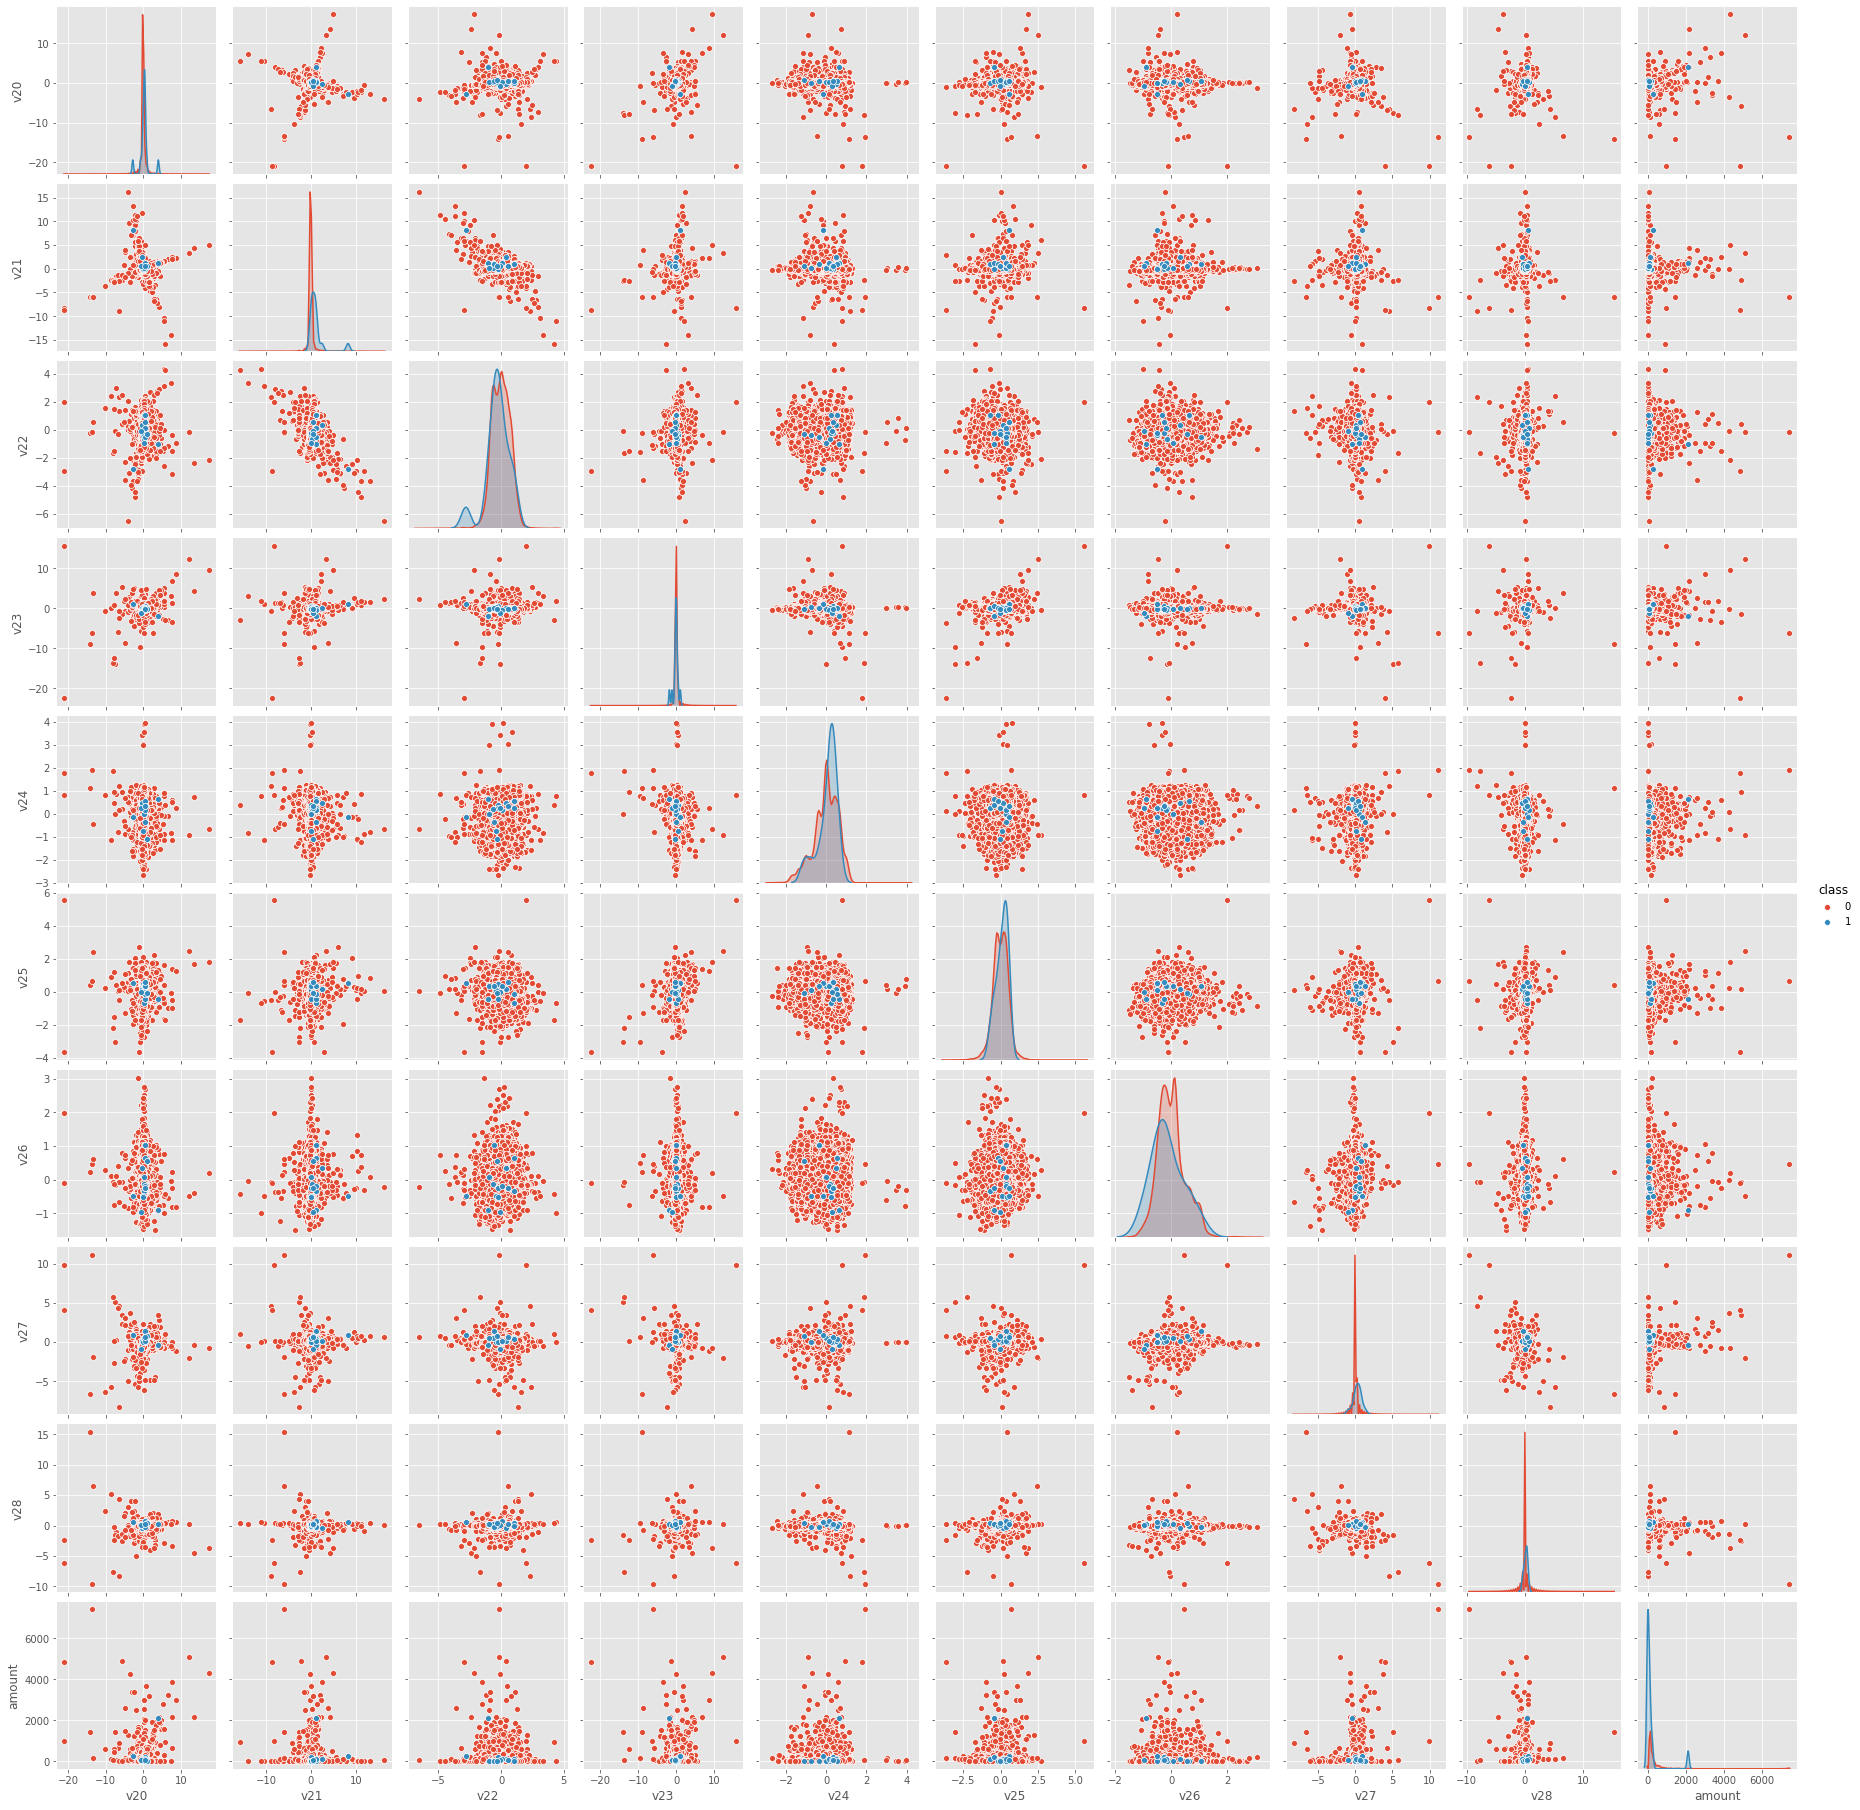

In [10]:
sns.pairplot(df[orig_feats[20:]+['class']].sample(10000, random_state=1), hue='class')

## Target Variable

In [19]:
target = 'class'

In [12]:
# Only 0.17% of the dataset is labelled as fraud
df[target].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: class, dtype: float64

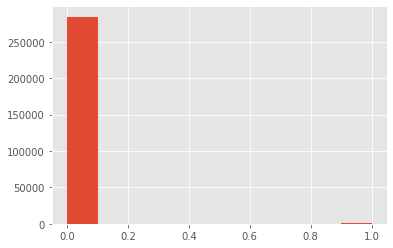

In [13]:
df[target].hist()

## Correlation Matrix

In [19]:
df_corr = df.corr()

In [20]:
df_corr.style.background_gradient().set_precision(2)

In [21]:
df.corr()['class'].sort_values()

v17      -0.326481
v14      -0.302544
v12      -0.260593
v10      -0.216883
v16      -0.196539
v3       -0.192961
v7       -0.187257
v18      -0.111485
v1       -0.101347
v9       -0.097733
v5       -0.094974
v6       -0.043643
time     -0.012323
v24      -0.007221
v13      -0.004570
v15      -0.004223
v23      -0.002685
v22       0.000805
v25       0.003308
v26       0.004455
amount    0.005632
v28       0.009536
v27       0.017580
v8        0.019875
v20       0.020090
v19       0.034783
v21       0.040413
v2        0.091289
v4        0.133447
v11       0.154876
class     1.000000
Name: class, dtype: float64

# Train, Test, Split

In [20]:
X = df[orig_feats]
y = df[target]

In [21]:
# Use stratify to ensure samples of fraud label are in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(213605, 30) (71202, 30) (213605,) (71202,)


In [22]:
y_train.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: class, dtype: float64

In [23]:
y_test.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: class, dtype: float64

# Modeling

## Predicting All Zeros

If we predict all 0's, what would be the AUC?

In [26]:
naive_preds = np.zeros(y_test.shape[0])
len(naive_preds)

71202

In [27]:
roc_auc_score(y_test, naive_preds)

0.5

In [28]:
print(classification_report(y_test, naive_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.00      0.00      0.00       123

    accuracy                           1.00     71202
   macro avg       0.50      0.50      0.50     71202
weighted avg       1.00      1.00      1.00     71202



## Naive Models 

Use cross validation and train naive models to see AUC scores and select model

In [13]:
num_boost_rounds = 1000
early_stopping_rounds = 10

initial_params = {'objective': 'binary:logistic', 'eval_metric': 'auc'}

In [105]:
logit_cv = cross_val_score(estimator=LogisticRegression(), 
                            X=X_train, 
                            y=y_train, 
                            scoring='roc_auc',
                            cv=StratifiedKFold(n_splits=5, random_state=1))

In [106]:
rf_cv = cross_val_score(estimator=RandomForestClassifier(),
                         X=X_train, 
                         y=y_train,
                         scoring='roc_auc',
                         cv=StratifiedKFold(n_splits=5, random_state=1))

In [107]:
xgb_cv = cross_val_score(estimator=XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                 early_stopping_rounds=early_stopping_rounds,
                                                 **initial_params),
                          X=X_train,
                          y=y_train,
                          scoring='roc_auc',
                          cv=StratifiedKFold(n_splits=5, random_state=1))

[14:13:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { early_stopping_rounds, num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:13:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { early_stopping_rounds, num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:14:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { early_stopping_rounds, num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in langu

In [108]:
print(f'Logistic Regression CV Mean AUC score: {logit_cv.mean()}')
print(f'Random Forest CV Mean AUC score: {rf_cv.mean()}')
print(f'XGBoost CV Mean AUC score: {xgb_cv.mean()}')


Logistic Regression CV Mean AUC score: 0.9106077670492301
Random Forest CV Mean AUC score: 0.9439131627467446
XGBoost CV Mean AUC score: 0.9704235200138237


In [109]:
model_cv_results = {'logit': logit_cv, 'random_forest': rf_cv, 'xgb': xgb_cv}

Text(0.5, 1.0, 'AUC scores using Different Classification Algorithms')

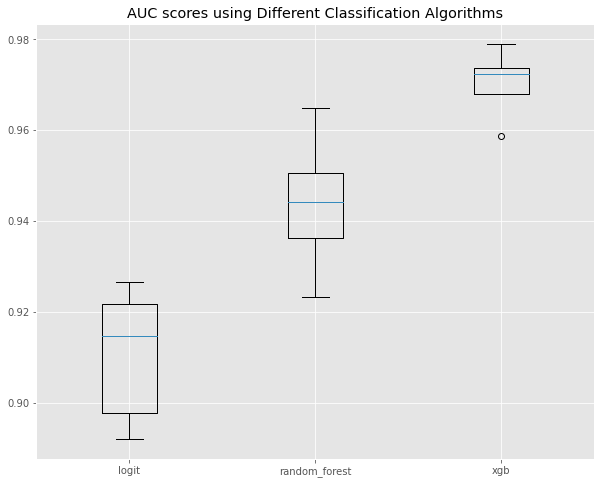

In [110]:
fig, ax = plt.subplots(figsize=(10,8))
plt.boxplot(model_cv_results.values())
ax.set_xticklabels(model_cv_results.keys())
plt.title('AUC scores using Different Classification Algorithms')

XGBoost performed the best, so select XGBoost as our model of choice going forward.

## Compare Sampling Methods

### Random Oversampling

Random Oversampling will sample the minority class with replacement until a defined threshold. The default sampling strategy will oversample the minority class until our new dataset has a 50/50 split between 0 and 1 labels.

In [58]:
oversamp_pipeline = imblearn.pipeline.Pipeline([('oversample', RandomOverSampler(random_state=42)),
                                                ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                                      early_stopping_rounds=early_stopping_rounds,
                                                                      **initial_params))])

### Random Undersampling

Random Undersampling will remove instances of the majority class until a defined threshold. The default sampling strategy will undersample the majority class (without replacement by default) until our new dataset has a 50/50 split between 0 and 1 labels.

In [59]:
undersamp_pipeline = imblearn.pipeline.Pipeline([('undersample', RandomUnderSampler(random_state=42)),
                                                 ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                                       early_stopping_rounds=early_stopping_rounds,
                                                                       **initial_params))])

### Oversampling - SMOTE

In [60]:
smote_pipeline = imblearn.pipeline.Pipeline([('smote', SMOTE(random_state=42)),
                                             ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                                   early_stopping_rounds=early_stopping_rounds,
                                                                   **initial_params))])

### Cross Validation to Compare Sampling Methods

In [61]:
sampling_methods = {'random_oversampling': oversamp_pipeline,
                    'random_undersampling': undersamp_pipeline,
                    'smote': smote_pipeline}

In [62]:
sampling_cv_results = {}

for method, pipeline in sampling_methods.items():
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=5, random_state=1), scoring='roc_auc')
    sampling_cv_results[method] = cv_results
    print(method, cv_results.mean())

random_oversampling 0.9737147148645258
random_undersampling 0.9759599618408392
smote 0.9741271783890648


Text(0.5, 1.0, 'AUC scores of XGB Classifier using Different Sampling Methods')

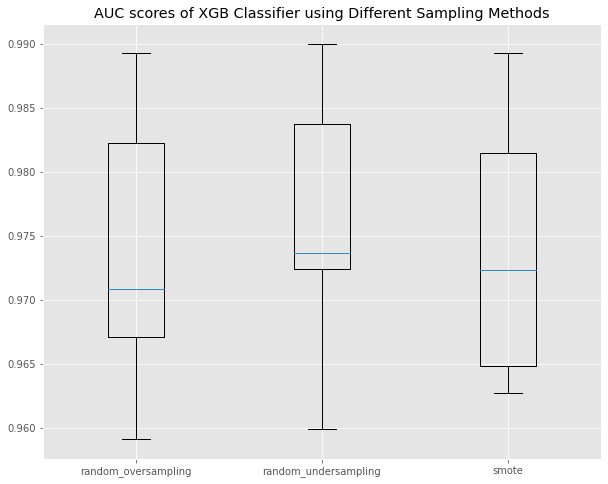

In [63]:
fig, ax = plt.subplots(figsize=(10,8))
plt.boxplot(sampling_cv_results.values())
ax.set_xticklabels(sampling_cv_results.keys())
plt.title('AUC scores of XGB Classifier using Different Sampling Methods')

# Bayesian Hyperparameter Tuning using Hyperopt

In [56]:
# Set up grid for hyperopt
space = {
    'max_depth': hp.quniform('max_depth', 4, 10, 2),
    'min_child_weight': hp.quniform('min_child_weight', 1, 20, 2),
    'gamma': hp.quniform('gamma', 0, 5, 0.5),
    'subsample': hp.uniform('subsample', 0.5, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.9),
    'eta': hp.uniform('eta', 0.01, 0.3),
    'objective': 'binary:logistic',
    'eval_metric': 'auc'
}

In [57]:
# Objective function
def objective(params):
    params = {'max_depth': int(params['max_depth']),
              'min_child_weight': int(params['min_child_weight']),
              'gamma': params['gamma'],
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'eta': params['eta'],
              'objective': params['objective'],
              'eval_metric': params['eval_metric']}
    
    xgb_clf = XGBClassifier(num_boost_rounds=num_boost_rounds, 
                            early_stopping_rounds=early_stopping_rounds,
                            **params)
    
    best_score = cross_val_score(xgb_clf, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=3).mean()
    
    loss = 1 - best_score 
    
    return loss

In [58]:
best_result = fmin(fn=objective, space=space, max_evals=20, 
                   rstate=np.random.RandomState(42), algo=tpe.suggest)

100%|██████████| 20/20 [22:42<00:00, 68.11s/trial, best loss: 0.021352304954586954]


In [59]:
best_result

{'colsample_bytree': 0.6544283029894612,
 'eta': 0.15242195929967656,
 'gamma': 1.5,
 'max_depth': 10.0,
 'min_child_weight': 6.0,
 'subsample': 0.8525913670531764}

In [60]:
best_params = best_result
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])
best_params['gamma'] = best_params['gamma']
best_params['colsample_bytree'] = round(best_params['colsample_bytree'], 1)
best_params['eta'] = round(best_params['eta'], 1)
best_params['subsample'] = round(best_params['subsample'], 1)
best_params

{'colsample_bytree': 0.7,
 'eta': 0.2,
 'gamma': 1.5,
 'max_depth': 10,
 'min_child_weight': 6,
 'subsample': 0.9}

# Evaluating Final Model Performance

## Train Final Model with Optimal Hyperparameters

In [61]:
final_model = imblearn.pipeline.Pipeline([('smote', SMOTE(random_state=1)),
                                          ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds,
                                                                early_stopping_rounds=early_stopping_rounds, 
                                                                **best_params))])

In [62]:
final_model.fit(X_train, y_train)

[11:40:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { early_stopping_rounds, num_boost_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, n_jobs=None, random_state=1,
                       sampling_strategy='auto')),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, early_stopping_rounds=10,
                               eta=0.2, gamma=1.5, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.200000003, max_delta_step=0,
                               max_depth=10, min_child_weight=6, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_boost_rounds=1000,
                               num_parallel_tree=1, objective='binary:logistic',
                               random_state

In [63]:
final_preds = final_model.predict_proba(X_test)[:,1]

## Save Final Model Predictions to .csv

In [64]:
test = pd.merge(X_test, y_test, left_index=True, right_index=True)
test.head()

time        v1        v2        v3        v4        v5        v6  \
170722  120325.0 -1.508324 -1.885971  0.562933 -2.385455  2.492496 -2.075875   
223193  143282.0  2.058549  0.109992 -1.726096  0.551365  0.016339 -1.568143   
220019  141984.0  2.106311  0.008430 -2.414074 -0.265062  0.958970 -0.749270   
219991  141967.0  1.930257 -0.340094 -0.214898  1.150924 -0.329949  0.417707   
178835  123804.0  1.937486 -2.092468 -0.477910 -1.912250 -0.921454  2.096362   

              v7        v8        v9  ...       v21       v22       v23  \
170722 -0.356142 -0.262901 -1.345529  ...  0.683503  1.467981 -0.077919   
223193  0.169459 -0.310102  0.821141  ...  0.177727  0.619307  0.000313   
220019  0.623262 -0.309529  0.009054  ...  0.171308  0.542624 -0.071912   
219991 -0.736411  0.116311  1.185489  ...  0.050936  0.293787  0.107512   
178835 -2.056233  0.632220 -0.941501  ...  0.045908  0.510007  0.273923   

             v24       v25       v26       v27       v28  amount  class  
170722 -0.331772  0.154573 -0.212628 -0.134447 -0.046227   15.00      0  
223193 -0.059154  0.201169 -0.098746 -0.012000 -0.034564    1.90      0  
220019  0.270319  0.459273  0.220342 -0.095939 -0.086313   12.25      0  
219991 -1.085460 -0.201620 -0.664436  0.081167 -0.023725   37.25      0  
178835 -0.956808 -0.711244 -0.160721  0.091467 -0.031877  110.11      0  

[5 rows x 31 columns]

In [65]:
test.shape

(71202, 31)

In [66]:
df_preds = test.copy()
df_preds['fraud_score'] = final_preds

In [67]:
df_preds.head()

time        v1        v2        v3        v4        v5        v6  \
170722  120325.0 -1.508324 -1.885971  0.562933 -2.385455  2.492496 -2.075875   
223193  143282.0  2.058549  0.109992 -1.726096  0.551365  0.016339 -1.568143   
220019  141984.0  2.106311  0.008430 -2.414074 -0.265062  0.958970 -0.749270   
219991  141967.0  1.930257 -0.340094 -0.214898  1.150924 -0.329949  0.417707   
178835  123804.0  1.937486 -2.092468 -0.477910 -1.912250 -0.921454  2.096362   

              v7        v8        v9  ...       v22       v23       v24  \
170722 -0.356142 -0.262901 -1.345529  ...  1.467981 -0.077919 -0.331772   
223193  0.169459 -0.310102  0.821141  ...  0.619307  0.000313 -0.059154   
220019  0.623262 -0.309529  0.009054  ...  0.542624 -0.071912  0.270319   
219991 -0.736411  0.116311  1.185489  ...  0.293787  0.107512 -1.085460   
178835 -2.056233  0.632220 -0.941501  ...  0.510007  0.273923 -0.956808   

             v25       v26       v27       v28  amount  class  fraud_score  
170722  0.154573 -0.212628 -0.134447 -0.046227   15.00      0     0.000015  
223193  0.201169 -0.098746 -0.012000 -0.034564    1.90      0     0.000122  
220019  0.459273  0.220342 -0.095939 -0.086313   12.25      0     0.000011  
219991 -0.201620 -0.664436  0.081167 -0.023725   37.25      0     0.000016  
178835 -0.711244 -0.160721  0.091467 -0.031877  110.11      0     0.000006  

[5 rows x 32 columns]

In [68]:
df_preds['fraud_score'].describe()

count    7.120200e+04
mean     2.226304e-03
std      4.222044e-02
min      2.634445e-07
25%      1.065991e-05
50%      2.553660e-05
75%      7.173139e-05
max      9.999990e-01
Name: fraud_score, dtype: float64

In [69]:
df_preds.to_csv('./final_model_preds.csv', index=False)

## Final Model Performance

In [70]:
roc_auc_score(y_test, final_preds)

0.9914615788204056

In [98]:
print(classification_report(y_test, final_preds.round()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.86      0.90      0.88       123

    accuracy                           1.00     71202
   macro avg       0.93      0.95      0.94     71202
weighted avg       1.00      1.00      1.00     71202



## Final Model Feature Importances

In [72]:
explainer = shap.TreeExplainer(final_model[1])

In [73]:
shap_values = explainer.shap_values(X_test)

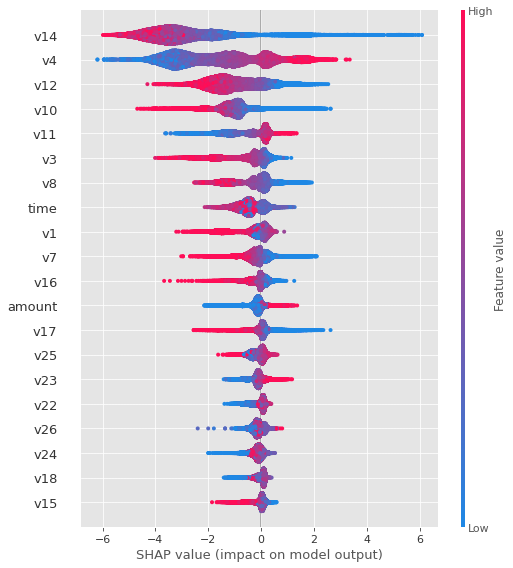

In [74]:
shap.summary_plot(shap_values, X_test)

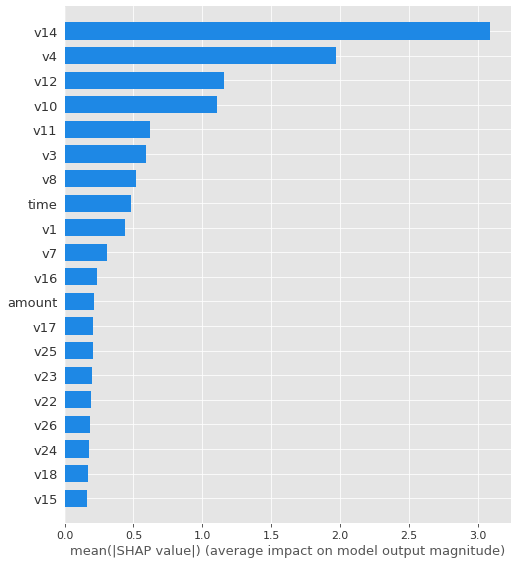

In [103]:
shap.summary_plot(shap_values, X_test, plot_type='bar')